# Energy Infrastructures 





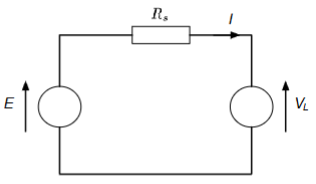

The Per Unit system 

The maximum power transfer possible is 1 p.u. 
$$V_{L} = E - IR_{s}$$

$ P_{L}= I \times V_{L} =  V_{L}\times \frac{E-  V_{L}}{ R_{s}}$
\\
And we have $ E = 1.0 $ and  $ R_{s}=0.1$
\\
$ P_{L} = 10 V_{L}(1- V_{L})$
\\
Maximum at $ V_{L}= 0.5$ 

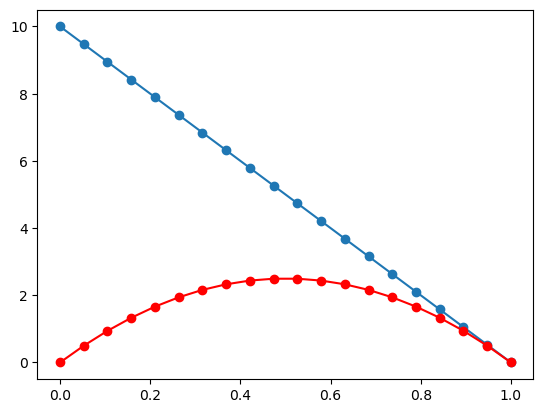

In [16]:
import numpy as np 
import matplotlib.pyplot as plt

V = np.linspace(0,1,20)
R = 0.1
E =1
P = []
I = []
for i in V:
    I.append((E - i)/R)
    P.append(i*(E- i)/R)

plt.plot(V, I, marker='o')
plt.plot(V,P, marker= 'o', color='red')
plt.show()
    

95% effiency means the $V_{L}= 0.95 \times V_{base}$
The efficiency of the circuit is $ \eta = \frac{P_{in_générateur}}{P_{out_charge}}$

We change with a resistance instead of juste a tension generator 
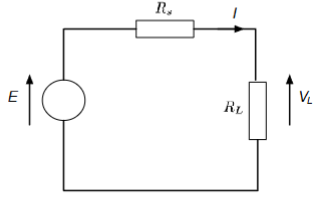

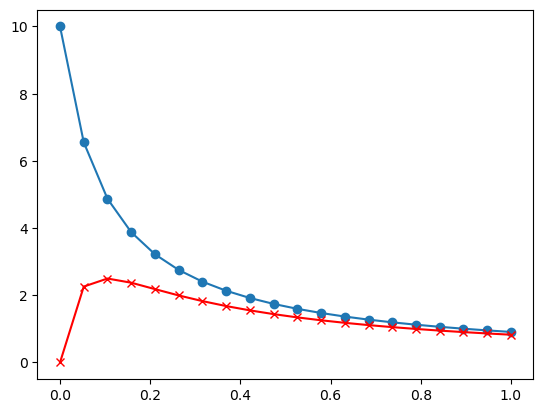

[0.0127016653792583, 0.787298334620742]
Maximum power is 2.49835634451019


In [26]:
!pip install sympy 
from sympy import symbols, Eq, solve

R_L = np.linspace(0,1, 20)
E = 1
R_s = 0.1
I = []
P =[]
for i in R_L :
    I.append(E/(R_s + i))
    P.append(i*(E/(R_s+i))**2)

plt.plot(R_L, I, marker = 'o')
plt.plot(R_L, P, marker = 'x', color = 'red')
plt.show()

x = symbols('x')
eq = Eq(x*(E/(x+R_s))**2 -1, 0)
print(solve(eq,x))

print("Maximum power is", max(P))

Calculer les valeurs de $R_{L}$ pour lequel P vaut 1 p.u.
Calculer P max 

# Cables 

Aluminium and copper cables ;   
buried cables costs >> overhead cables costs   
buried cables = sismic activity ; thicker cables because reduced resistance needed because less heat losses needed (the ground is acting as a insulator).   
overhead cables = typhoons   
  
Calculate cost of copper/alu wires based on the voltage being 240V, assuming 5% losses in the wire and knowing the power requirements x KW to be carried over a distance d ; 

# Optimisation problem 
  
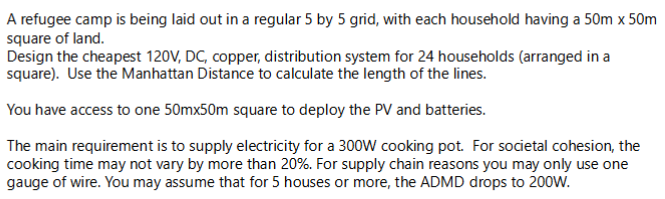



In [3]:
# Cable optimizer for 5x5 grid (center source) using copper gauges
# - MST topology (Manhattan distances)
# - ADMD: branch with >=5 houses -> P_nom_house = 200 W, else 300 W
# - Constraint: delivered power >= 0.8 * P_nom_house for every house
# - Cost: total cable length (one-way summed for all houses) * 2 conductors * cost_per_m
!pip install networkx
import math
import numpy as np
import networkx as nx
import pandas as pd

# -----------------------------
# Parameters / cable database
# -----------------------------
# [Name, Section mm2, R_ohm_per_km, cost_eur_per_m, I_max_A]
cables = [
    ["Cu-1.5mm2",   1.5, 12.1, 0.45, 15],
    ["Cu-2.5mm2",   2.5, 7.41, 0.60, 21],
    ["Cu-4mm2",     4.0, 4.61, 0.85, 28],
    ["Cu-6mm2",     6.0, 3.08, 1.10, 36],
    ["Cu-10mm2",   10.0, 1.83, 1.70, 50],
    ["Cu-16mm2",   16.0, 1.15, 2.60, 68],
    ["Cu-25mm2",   25.0, 0.727,3.80, 90],
    ["Cu-35mm2",   35.0, 0.524,5.10,110],
    ["Cu-50mm2",   50.0, 0.387,6.60,140]
]

# Grid and electrical params
grid_size = 5
spacing = 50.0  # meters between adjacent grid cells
source = (3, 3)  # central cell (1-indexed)
V_source = 120.0  # V DC
# ADMD rules
P_high = 300.0  # W when branch serves <5 houses
P_low  = 200.0  # W when branch serves >=5 houses
tolerance = 0.8  # must deliver at least 80% of P_nom

# -----------------------------
# Build nodes and MST (Manhattan)
# -----------------------------
nodes = [source] + [(i, j) for i in range(1, grid_size+1) for j in range(1, grid_size+1) if (i, j) != source]
G = nx.Graph()
for n in nodes:
    G.add_node(n)
# complete graph with Manhattan distances as weights
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        a = nodes[i]; b = nodes[j]
        dist = (abs(a[0]-b[0]) + abs(a[1]-b[1])) * spacing
        G.add_edge(a, b, weight=dist)

T = nx.minimum_spanning_tree(G, weight='weight')  # tree topology
# compute parent map rooted at source
parent = {source: None}
stack = [source]
while stack:
    n = stack.pop()
    for nb in T.neighbors(n):
        if nb not in parent:
            parent[nb] = n
            stack.append(nb)

# helper: compute subtree houses counts for each child-of-source
def subtree_nodes(tree, root):
    adj = {n: list(tree.neighbors(n)) for n in tree.nodes()}
    parent = {root: None}
    stack = [root]
    order = [root]
    while stack:
        node = stack.pop()
        for nb in adj[node]:
            if nb not in parent:
                parent[nb] = node
                stack.append(nb)
                order.append(nb)
    sizes = {n: 1 for n in tree.nodes()}
    for n in reversed(order):
        p = parent[n]
        if p is not None:
            sizes[p] = sizes.get(p,0) + sizes.get(n,0)
    return sizes, parent, adj

sizes, parent_map, adj = subtree_nodes(T, source)

# houses list (coordinates); each house is any node != source
houses = [n for n in nodes if n != source]

# For branch counts: neighbors of source and number of houses in that neighbor subtree
branch_counts = {}
for nb in adj[source]:
    # number of houses downstream excluding source node (sizes includes nodes count)
    branch_counts[nb] = sizes[nb]  # includes the neighbor itself if it's a house

# Assign P_nom for each house based on which branch it belongs to
# find for each house its top-level neighbor (first hop from source)
def first_hop(house, parent_map):
    # walk up until parent is source; return the child-of-source
    node = house
    while parent_map[node] != source:
        node = parent_map[node]
    return node

house_Pnom = {}
for h in houses:
    hop = first_hop(h, parent_map)
    # branch house count = branch_counts[hop], but sizes counts nodes (including internal); all nodes except source are houses here
    count = branch_counts[hop]
    # If count >=5 use P_low else P_high
    Pnom = P_low if count >= 5 else P_high
    house_Pnom[h] = Pnom

# -----------------------------
# Build linear system for node voltages
# Unknowns: voltage at every non-source node
# Equations for node i: V_i = V_parent - r_edge_i * sum_{k in subtree(i) & houses} (V_k / R_load_k)
# Rearranged linear form -> we build matrix A and vector b
# -----------------------------
# helper: get subtree house list for a node
def subtree_house_list(node, parent_map, adj):
    # collect nodes in subtree rooted at node (excluding parent)
    res = []
    stack = [node]
    visited = set([parent_map[node]]) if parent_map[node] is not None else set()
    while stack:
        n = stack.pop()
        if n != source and n in houses:
            res.append(n)
        for nb in adj[n]:
            if nb not in visited and nb != n:
                visited.add(n)
                # avoid going back to parent
                if parent_map.get(nb, None) == n or parent_map.get(n, None) == nb or parent_map.get(nb, None) is not None:
                    stack.append(nb)
    return res

# Precompute edge lengths and per-edge round-trip resistance (depends on cable R_per_m)
edge_lengths = {}
for a,b,data in T.edges(data=True):
    length_m = data['weight']  # already Manhattan * spacing
    edge_lengths[(a,b)] = length_m
    edge_lengths[(b,a)] = length_m

# function to evaluate a given cable
def evaluate_cable(R_ohm_per_km, cost_per_m, Imax):
    R_per_m = R_ohm_per_km / 1000.0
    # compute round-trip resistance for each edge (2 conductors)
    r_edge = {}
    for (a,b), L in list(edge_lengths.items()):
        r_edge[(a,b)] = 2.0 * R_per_m * L  # round-trip resistance for that edge when current flows through it
    
    # unknown index mapping for nodes (non-source)
    unknown_nodes = [n for n in nodes if n != source]
    idx = {n:i for i,n in enumerate(unknown_nodes)}
    N = len(unknown_nodes)
    A = np.zeros((N,N))
    b = np.zeros(N)
    
    # For each unknown node i (non-source), create equation:
    # V_i + r_edge(i, parent(i)) * sum_{k in houses_in_subtree_i} ( V_k / R_load_k ) - V_parent = 0
    # If parent is source, move V_parent=V_source to RHS.
    # We will express each V_k as unknown if k != source.
    # Build mapping of subtree houses for each node
    # precompute R_load_k for each house using its P_nom (R = V_source^2 / P_nom)
    R_load = {h: (V_source**2) / house_Pnom[h] for h in houses}
    
    # compute subtree houses for each node (we need correct subtree; do a DFS using parent_map)
    # Build children adjacency from parent_map
    children = {}
    for n,p in parent_map.items():
        if p is None: continue
        children.setdefault(p, []).append(n)
    # function to get houses in subtree rooted at node
    def houses_in_subtree(node):
        res = []
        stack = [node]
        while stack:
            cur = stack.pop()
            if cur in houses:
                res.append(cur)
            for c in children.get(cur, []):
                stack.append(c)
        return res

    # Build matrix
    for n in unknown_nodes:
        i = idx[n]
        p = parent_map[n]
        # edge resistance between n and parent p (round-trip)
        r_np = r_edge.get((n,p), r_edge.get((p,n), 0.0))
        # list of houses in subtree rooted at n
        subtree_h = houses_in_subtree(n)
        # For each leaf k in subtree: coefficient on V_k is r_np * (1/R_load_k)
        for k in subtree_h:
            if k == n:
                # V_n coefficient: 1 + r_np*(1/R_load_n)
                A[i,i] += 1.0 + r_np * (1.0 / R_load[k])
            else:
                # k is different unknown node => find its index
                if k == source: 
                    continue
                j = idx[k]
                A[i,j] += r_np * (1.0 / R_load[k])
        # subtract V_parent coefficient
        if p != source:
            # V_parent is an unknown -> move -1 * V_parent to LHS
            j = idx[p]
            A[i,j] += -1.0
        else:
            # parent is source -> move V_source to RHS
            b[i] = V_source
    
    # Solve linear system A x = b for node voltages
    try:
        V_vec = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None  # singular matrix -> not feasible topology/cable
    
    # map voltages back
    V_node = {source: V_source}
    for n in unknown_nodes:
        V_node[n] = V_vec[idx[n]]
    
    # compute delivered power at each house: P = V_house^2 / R_load_house
    delivered = {}
    ok_all = True
    for h in houses:
        Vh = V_node[h]
        Ph = Vh**2 / R_load[h]
        delivered[h] = Ph
        # check current rating on path: current in branch edges must not exceed Imax
        # compute current drawn by subtree at each edge by summing Ph/Vh for leaves (I = V/R_load)
    # compute currents on each edge (flow towards source)
    edge_current = {}
    # post-order compute total current in subtree rooted at node
    subtree_current = {}
    for n in reversed(list(nx.dfs_postorder_nodes(T, source))):
        if n == source:
            continue
        # current drawn by node if it's a house
        cur = 0.0
        if n in houses:
            cur += delivered[n] / R_load[n]  # I = V/R_load = Ph/V
        # add currents from children
        for c in children.get(n, []):
            cur += subtree_current.get(c, 0.0)
        subtree_current[n] = cur
        # current in edge n<-parent is subtree_current[n]
        edge_current[(n, parent_map[n])] = cur
    
    # check currents vs Imax
    for (a,b), Iedge in edge_current.items():
        if Iedge > Imax + 1e-9:
            ok_all = False
            break
    
    # check power tolerances
    for h in houses:
        Pnom = house_Pnom[h]
        if delivered[h] < tolerance * Pnom - 1e-9:
            ok_all = False
            break
    
    # compute total cable cost: sum of one-way lengths to each house * 2 conductors * cost_per_m
    total_oneway_len = sum(((abs(h[0]-source[0]) + abs(h[1]-source[1])) * spacing) for h in houses)
    total_cost = total_oneway_len * 2.0 * cost_per_m
    
    return {
        "V_node": V_node,
        "delivered": delivered,
        "edge_current": edge_current,
        "ok_all": ok_all,
        "total_cost": total_cost
    }

# -----------------------------
# Evaluate all cables and pick best feasible (min cost)
# -----------------------------
results = []
for name, area, R_km, cost_per_m, Imax in cables:
    out = evaluate_cable(R_km, cost_per_m, Imax)
    if out is None:
        feasible = False
        cost = math.inf
    else:
        feasible = out["ok_all"]
        cost = out["total_cost"]
    results.append((name, area, R_km, cost_per_m, Imax, feasible, cost))

df = pd.DataFrame(results, columns=["Name","Area_mm2","R_ohm_per_km","€/m","Imax_A","Feasible","Total_cost_€"])
df_sorted = df.sort_values(["Feasible","Total_cost_€"], ascending=[False, True])
print(df_sorted.to_string(index=False))

# Show best feasible
feasible_df = df[df["Feasible"]==True].sort_values("Total_cost_€")
if len(feasible_df)>0:
    best = feasible_df.iloc[0]
    print("\nBest feasible cable:", best['Name'], "- Section:", best['Area_mm2'], "mm^2 - Cost: €", best['Total_cost_€'])
else:
    print("\nNo cable meets the constraints with current assumptions. Consider: larger gauge, different topology or relax constraints.")


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 5.7 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.0 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 4.7 MB/s  0:00:00
     Name  Area_mm2  R_ohm_per_km  €/m  Imax_A  Feasible  Total_cost_€
 Cu-16mm2      16.0         1.150 2.60      68      True       15600.0
 Cu-25mm2      25.0         0.727 3.80      90      True       22800.0
 Cu-35mm2      35.0         0.524 5.10     110      True       30600.0
 Cu-50mm2      50.0         0.387 6.60     140      True       39600.0
Cu-1.5mm2       1.5        12.100 0.45      15     False        2700.0
Cu-2.5mm2       2.5         7.410 0.60      21     False        3600.0
  Cu-4mm2       4.0         4.610 0.85      28     False        5100.0
  Cu-6mm2       6.0         3.080 1.10      36     False        6600.0
 Cu-10mm2      10.0         1.830 1.70      50     False       1020

In [11]:
V =120
I = 300/120
R_L = 200
n=6
V_six_result = V - I*R_L* n*(n+1)/2

R=[]
V_copp = []
for i in range(len(cables)) :
    R.append(0.6*cables[i][2])
    V_copp.append(V - I*R[-1]*n*(n+1)/2)
    #print(R[-1], V_copp[-1])
    if V_copp[-1] > 107 : 
        print(cables[i][0])
        print(cables[i][3]*2400)

    

Cu-50mm2
15840.0


# AC Power flow 

Goal : to assess the power (real and reactive and apparent) in a *AC power flow circuit* and add the angles and imaginary components in Python.  

_Deal with j in Python_
  
Exercice : 

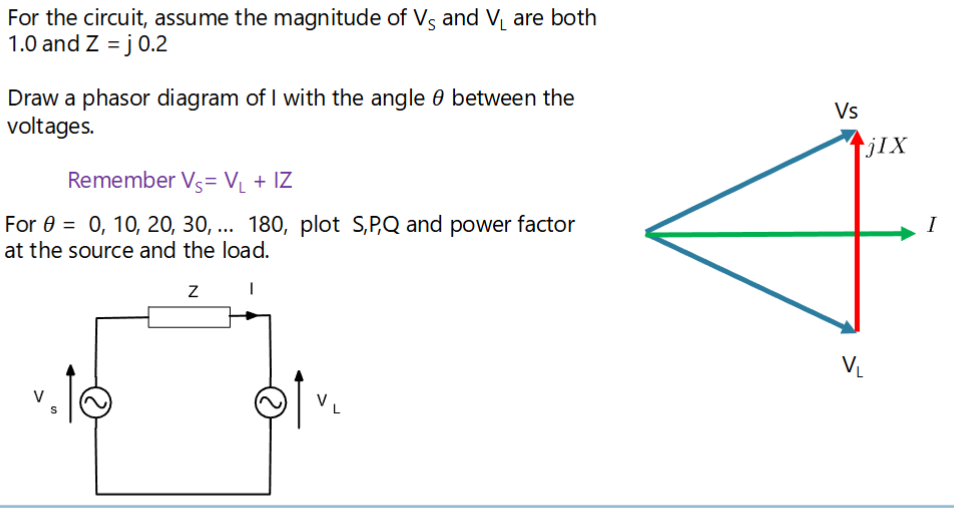


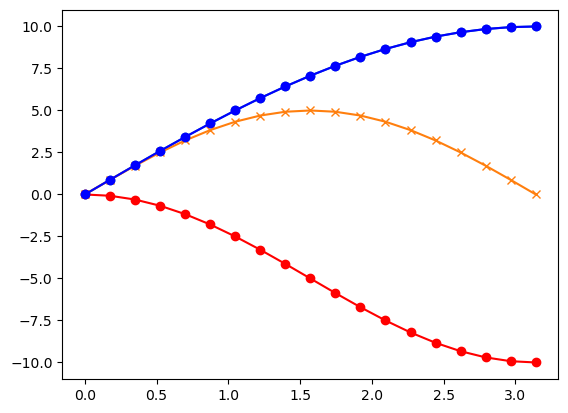

In [17]:
import numpy as np
import matplotlib.pyplot as plt

v = 1
x= 0.2
tet_list =  [10*k*np.pi/180 for k in range(0,19)]
I=[]
P=[]
Q=[]
S=[]

for tet in tet_list: 
    I.append(2*v*np.sin(tet/2)/x)
    P.append(v*I[-1]*np.cos(tet/2))
    Q.append(-v*I[-1]*np.sin(tet/2))
    ### Attention : c'est -Q qu'on cherche parce qu'il y a une multiplication par le conjugué (c'est une façon de voir ce qui sort de la source et pas ce qui y rentre, contrairement à ce qu'on calcule pour une load)
    S.append(np.sqrt(Q[-1]**2 + P[-1]**2))

plt.plot(tet_list, I, marker='o')
plt.plot(tet_list, P, marker='x')
plt.plot(tet_list, Q, marker='o', color = 'red')
plt.plot(tet_list, S, marker='o', color = 'blue')

plt.show()


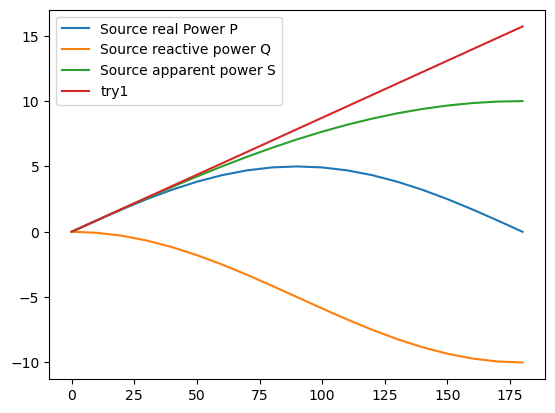

In [15]:
#Correction 

thetas = np.arange(0,181,10)
vs_mag = 1  #magnitude of the load 
vl_mag = 1  #magnitude of the source 
x = 0.2   #reactance in ohms

#vs is the reference 
#notation complexe
Vs= vs_mag +0j*vs_mag  
Vl = vl_mag*np.cos(np.deg2rad(thetas)) + 1j*vl_mag*np.sin(np.deg2rad(thetas))
Z = 0 +1j*x

# calculus (equation electrique) 
I = (Vs-Vl)/Z

Ss= -1*Vs*np.conj(I)
# P est la partie réelle de Ss, Q est la partie imaginaire

P = (vs_mag**2)*np.deg2rad(thetas)/x


plt.plot(thetas, Ss.real, label = 'Source real Power P')
plt.plot(thetas, Ss.imag, label = 'Source reactive power Q')
plt.plot(thetas, np.abs(Ss), label = 'Source apparent power S')
plt.plot(thetas, P, label = 'try1')
plt.legend()
